# Topic modeling on subreddit data
Shahar Cohen

The assignment comprises the following components:
1. Apply basic data cleaning techniques.
2. Use a topic modeling approach to categorize posts by topic (in this stage, don’t use the subreddit
column).
3. Use the topic modeling outputs to find real-world events in the data over time.
4. Evaluate your topic modeling results using the subreddit column.

Additional guidelines:
* Implement your solution using Python and Jupyter Notebook.
* Include instructions for running your code as necessary.
* Note that the objective is not to create the optimal model or achieve flawless data cleaning but to
demonstrate data manipulation, modeling capabilities, and business orientation.
* Please explain your decisions and include visualizations where appropriate.

In [1]:
# Import neccessary libraries for text processing abd data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
#retina display
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bertopic import BERTopic
from umap import UMAP
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN


/Users/shaharcohen/opt/anaconda3/envs/mana/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Explore and preprocess the data

In [2]:
# Load the dataset
data_path = './data/reddit_data.csv'
df = pd.read_csv(data_path)
df.head()

,author,body,created_utc,subreddit,id,score
0,malcontent,&gt;The business cannot survive paying out ben...,2008-12-18 08:00:37,politics,2,1
1,malcontent,"&gt;I'm curious, how do you see, beyond defini...",2008-12-18 08:00:41,politics,3,1
2,malcontent,"&gt;I'm curious, how do you see, beyond defini...",2008-12-18 08:00:53,politics,4,2
3,[deleted],[deleted],2008-12-18 08:01:07,WTF,5,1
4,catalytica,The greatest historic instigator of human divi...,2008-12-18 08:01:20,atheism,7,0


Exploring the dataset we can specify the column and their meaning:
1. **author**: The username of the person who posted the comment or submission on Reddit. For example, "malcontent" or "[deleted]".

2. **body**: The content of the comment or submission. For example, "The business cannot survive paying out ben..." or "[deleted]".

3. **created_utc**: The timestamp of when the comment or submission was created, in Coordinated Universal Time (UTC). For example, "2008-12-18 08:00:37".

4. **subreddit**: The name of the subreddit where the comment or submission was posted. For example, "politics" or "WTF".

5. **id**: A unique identifier for the comment or submission. For example, "2" or "5".

6. **score**: The net score of the comment or submission, calculated as the difference between upvotes and downvotes. For example, "1" or "0".

In [3]:
# Convert created_utc to datetime
df['created_utc'] = pd.to_datetime(df['created_utc'])
# Display the first 5 rows of the dataset
display(df.head())
# Display basic information
print("Basic Information:")
print(df.info())

,author,body,created_utc,subreddit,id,score
0,malcontent,&gt;The business cannot survive paying out ben...,2008-12-18 08:00:37,politics,2,1
1,malcontent,"&gt;I'm curious, how do you see, beyond defini...",2008-12-18 08:00:41,politics,3,1
2,malcontent,"&gt;I'm curious, how do you see, beyond defini...",2008-12-18 08:00:53,politics,4,2
3,[deleted],[deleted],2008-12-18 08:01:07,WTF,5,1
4,catalytica,The greatest historic instigator of human divi...,2008-12-18 08:01:20,atheism,7,0


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558353 entries, 0 to 558352
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   author       558353 non-null  object        
 1   body         558352 non-null  object        
 2   created_utc  558353 non-null  datetime64[ns]
 3   subreddit    558353 non-null  object        
 4   id           558353 non-null  object        
 5   score        558353 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 25.6+ MB
None


In [4]:
# Convert the data types of the columns
df['subreddit'] = df['subreddit'].astype('category')
df['author'] = df['author'].astype('category')

In [5]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
author         0
body           1
created_utc    0
subreddit      0
id             0
score          0
dtype: int64


As we can see we have only one missing value in the dataset so we can remove it or complete it using statistical approach.

Since it is only one we will remove it.

In [6]:
# Remove missing values
df.dropna(inplace=True)
print("\nMissing Values after removing:")
print(df.isnull().sum())


Missing Values after removing:
author         0
body           0
created_utc    0
subreddit      0
id             0
score          0
dtype: int64


In [7]:
# Generate summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
                         created_utc          score
count                         558352  558352.000000
mean   2008-12-16 04:48:25.744838144       3.878335
min              2008-12-01 02:00:01    -594.000000
25%       2008-12-08 18:39:05.500000       1.000000
50%              2008-12-16 02:06:19       1.000000
75%       2008-12-23 14:36:50.500000       3.000000
max              2009-01-01 01:59:58    1472.000000
std                              NaN      13.235561


The dataset contain about 500,000 reddit posts. As we can see from the statitics more then 75% has a score of lower then 3. Lets see the score distrebution.

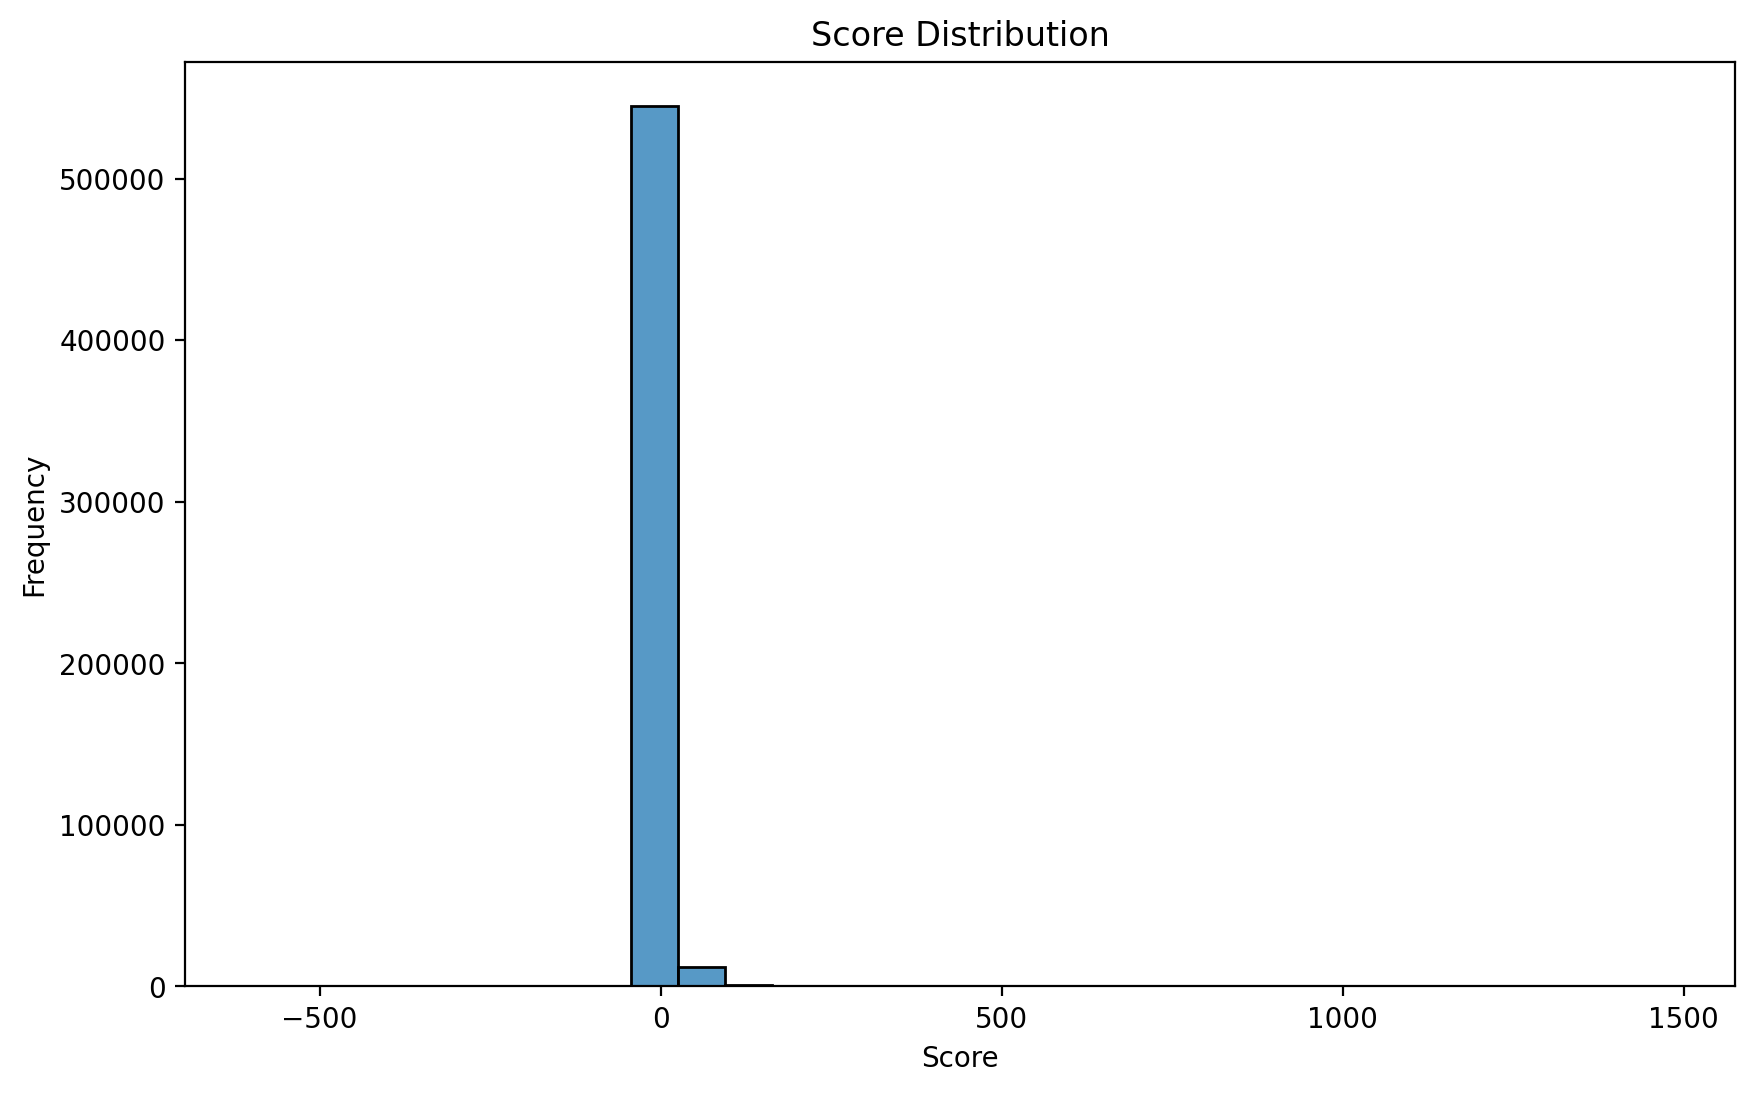

In [8]:
# Plot the score distribution 
plt.figure(figsize=(10,6))
sns.histplot(df['score'], bins=30)
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

Since we are doing topic modeling, addressing the score column helps filter out low-quality or irrelevant posts, reduce noise, and improve model accuracy.

The Interquartile Range (IQR) method is a statistical technique used to identify and handle outliers in a dataset. Here's how it works:

1. Calculate Quartiles:

* Q1 (First Quartile): The 25th percentile of the data.
* Q3 (Third Quartile): The 75th percentile of the data.
2. Compute IQR:

* IQR = Q3 - Q1
3. Determine Outlier Boundaries:

* Lower Bound: Q1 - 1.5 * IQR
* Upper Bound: Q3 + 1.5 * IQR
4. Identify Outliers:

* Any data point below the lower bound or above the upper bound is considered an outlier.

The IQR method is robust and less sensitive to extreme values compared to other methods, making it effective for detecting outliers in skewed distributions.

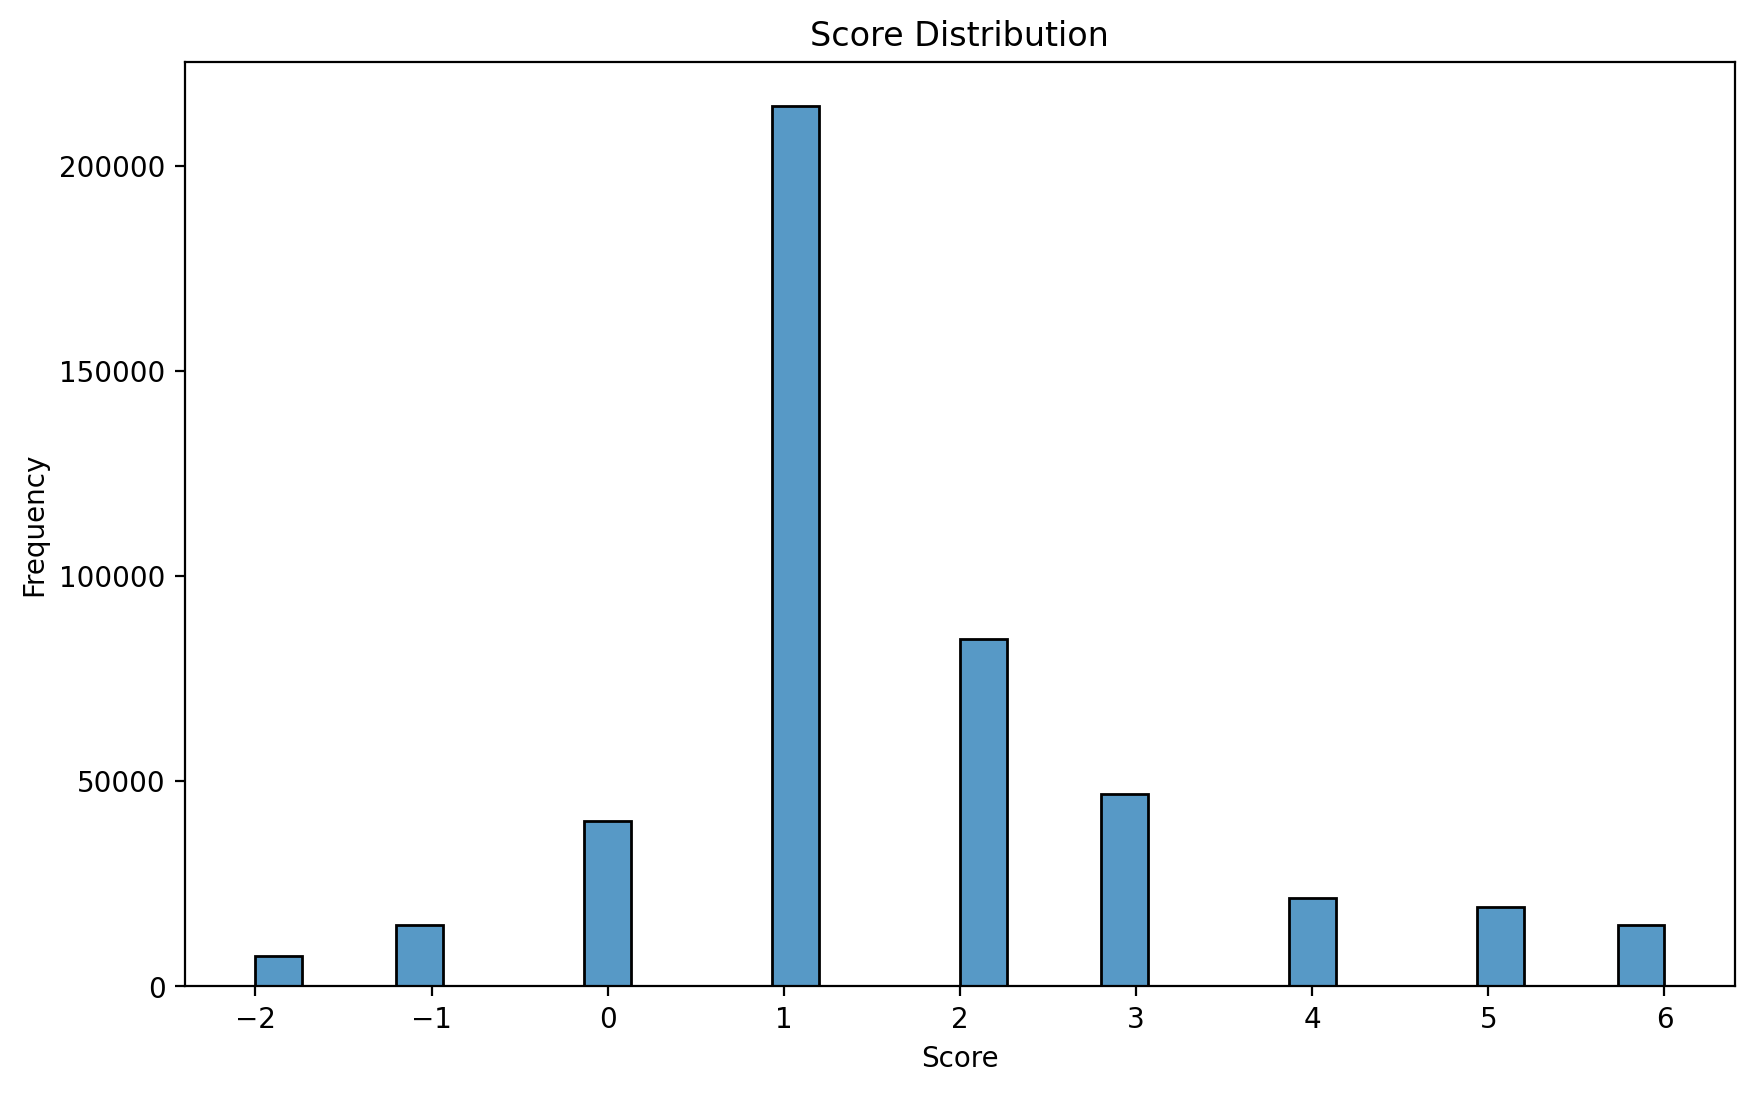

In [9]:
# Remove score outliers by using the IQR method
Q1 = df['score'].quantile(0.25)
Q3 = df['score'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['score'] >= Q1 - 1.5*IQR) & (df['score'] <= Q3 + 1.5*IQR)]
# Plot the score distribution after removing outliers
plt.figure(figsize=(10,6))
sns.histplot(df['score'], bins=30)
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


In [10]:
print("The length of the dataset after removing outliers is: ", len(df))

The length of the dataset after removing outliers is:  464559


Now I'll explore the author column

In [11]:
# Explor the author column
print("Number of unique authors: ", df['author'].nunique())
print("Top 10 authors with the most posts: ")
print(df['author'].value_counts().head(10))

Number of unique authors:  25505
Top 10 authors with the most posts: 
author
[deleted]              152016
malcontent               1083
FokkeNews                 843
yehauma                   751
mexicodoug                713
neuromonkey               638
redditcensoredme          595
IConrad                   556
ContentWithOurDecay       527
mindbleach                511
Name: count, dtype: int64


Most of the authors were deleted, lets make sure the body isn't deleted,

In [12]:
df[df['author'] == '[deleted]'].head()

,author,body,created_utc,subreddit,id,score
3,[deleted],[deleted],2008-12-18 08:01:07,WTF,5,1
7,[deleted],[deleted],2008-12-18 08:01:44,WTF,b,4
14,[deleted],[deleted],2008-12-18 08:02:31,atheism,m,1
24,[deleted],"He's a Rifle man, what should he do?",2008-12-18 08:04:50,WTF,14,2
28,[deleted],[deleted],2008-12-18 08:05:18,funny,1b,1


In [13]:
# Let's view the number of unique body values
print("Number of unique body values: ", df['body'].nunique())
print(df['body'].value_counts().head(10))

Number of unique body values:  388618
body
[deleted]                    68997
No.                            164
Yes.                           132
Why?                            64
lol                             55
[citation needed]               52
I see what you did there.       50
What?                           50
no                              49
.                               49
Name: count, dtype: int64


Usually I would remove the body with only 2-3 words but since there is a WTF subreddint it should fit there in the topic modeling.

In [14]:
# Remove the deleted body values
df = df[df['body'] != '[deleted]']

In [15]:
# Making sure the [deleted] autors has body text
deleted_authors = df[df['author'] == '[deleted]']
print("Number of posts with [deleted] author: ", len(deleted_authors))
print("Number of posts with [deleted] author and body text: ", len(deleted_authors[deleted_authors['body'] != '[deleted]']))
print("Number of posts with [deleted] author and no body text: ", len(deleted_authors[deleted_authors['body'] == '[deleted]']))

Number of posts with [deleted] author:  83027
Number of posts with [deleted] author and body text:  83027
Number of posts with [deleted] author and no body text:  0


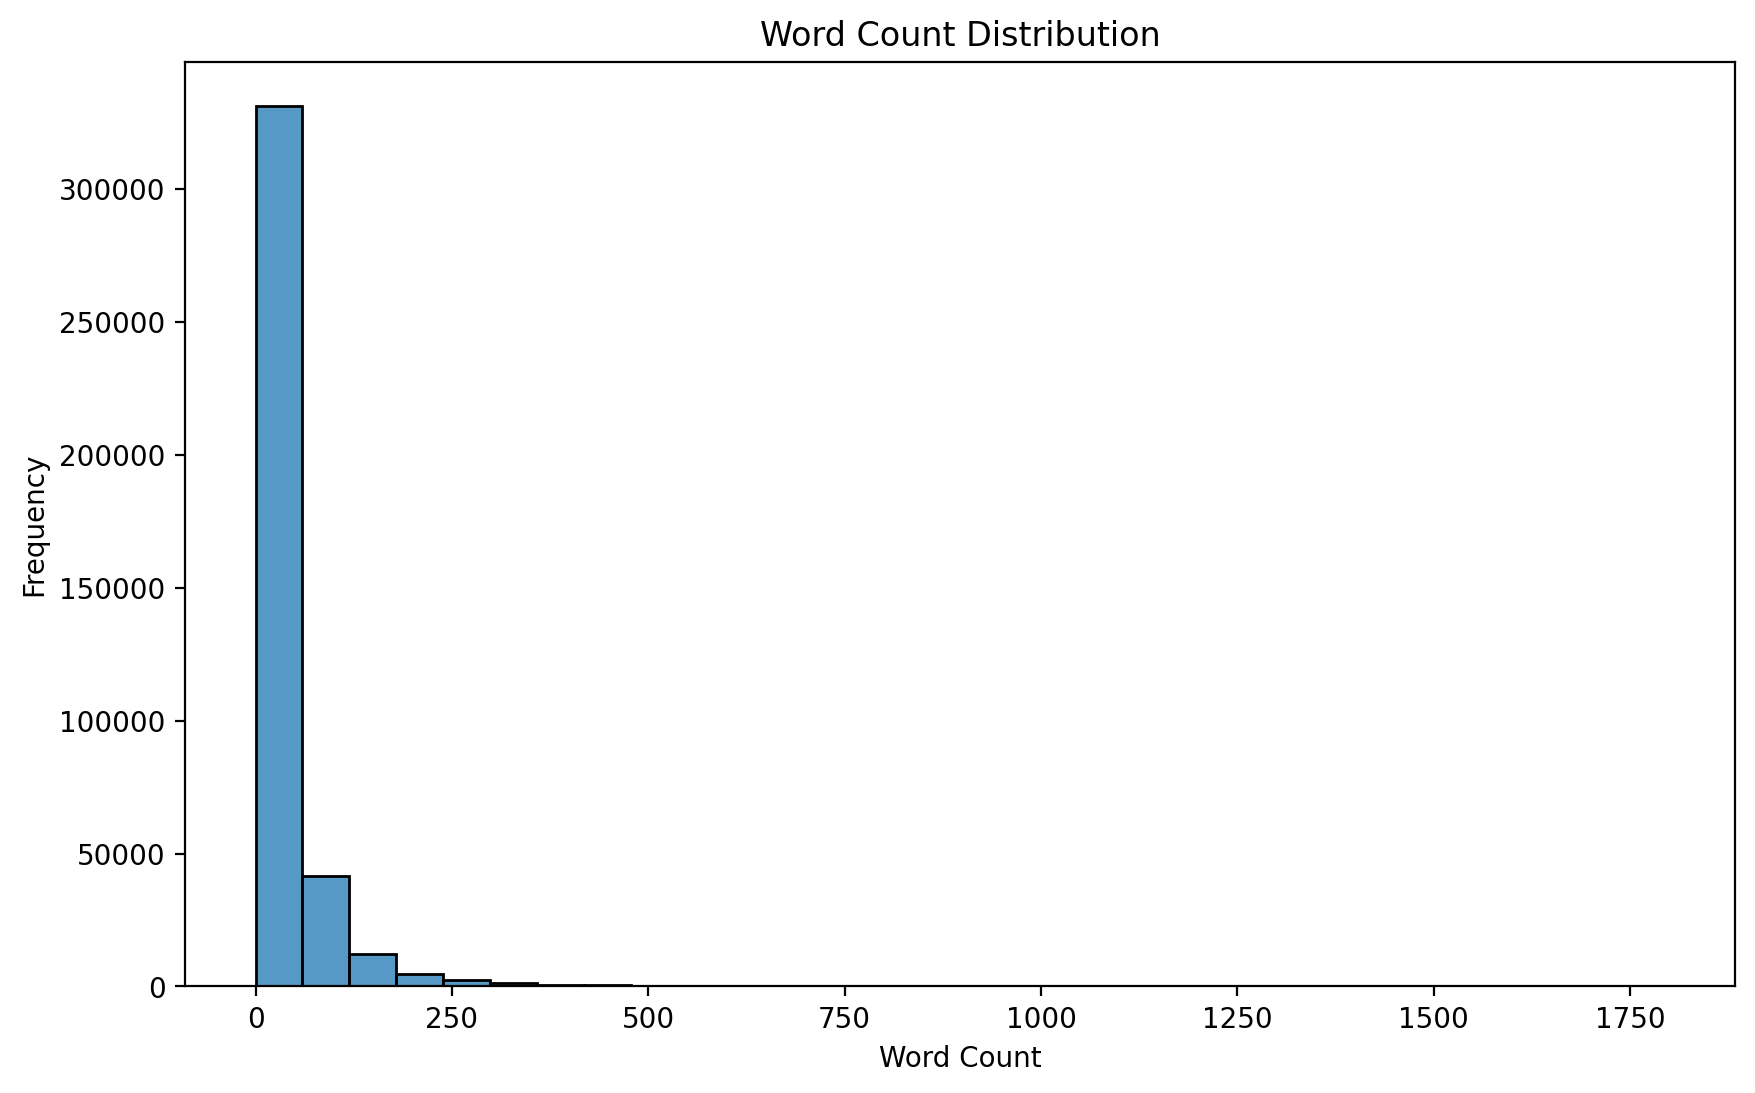

In [16]:
# Plot word count distribution
df['word_count'] = df['body'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,6))
sns.histplot(df['word_count'], bins=30)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

Most of the body's contain a small number of words. Since I am not supposed to consider the subreddit at this stage, I will not analyze the word count distribution with a hue of subreddit.

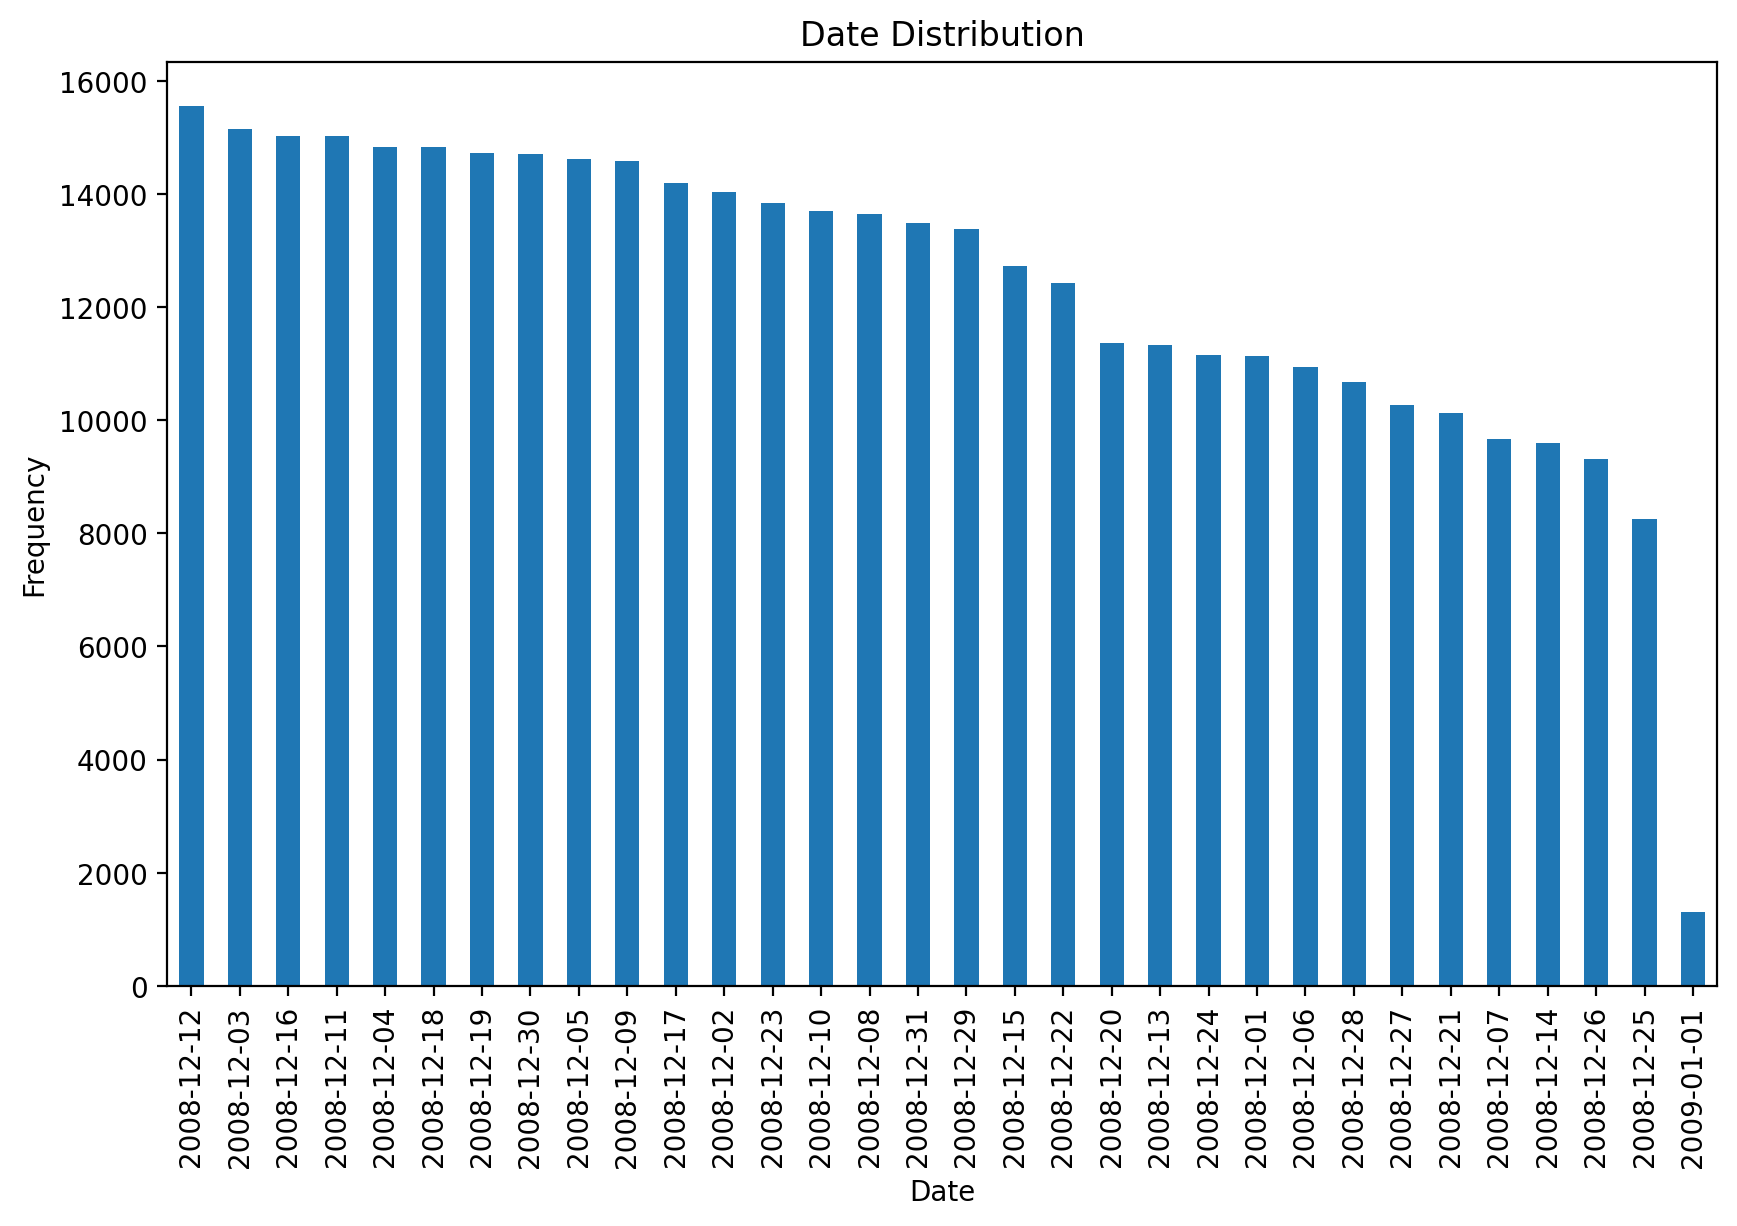

In [17]:
# histogram of date distribution
plt.figure(figsize=(10,6))
df['created_utc'].dt.date.value_counts().plot(kind='bar')
plt.title('Date Distribution')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

The date distribution looks decent across the month so we will not change anything here.
The last week of the month has lest posts, I dont think it will bother us. We can use more methids to add posts such as SMOTE or diffrent sampling method to fix the unbalanced data.

Now ill make sure the id is unique

In [18]:
# id column unique values
print(f"Number of unique id values: {df['id'].nunique()}, Number of total samples {len(df)}")

Number of unique id values: 395562, Number of total samples 395562


Great, now we can move to the body cleanning phase:

Removing stopwords, hashtags, and URLs, and tokenizing and lemmatizing text are important steps in text preprocessing for the following reasons:

1. **Remove Stopwords**: Stopwords (common words like "and", "the", "is") do not carry significant meaning and can clutter the analysis. Removing them helps in focusing on the more meaningful words.

2. **Remove Hashtags and URLs**: Hashtags and URLs often do not contribute to the content's semantic meaning and can introduce noise. Removing them ensures cleaner input.

3. **Tokenization**: Tokenizing text (splitting it into individual words or tokens) is essential for analyzing the text at the word level. It allows for more detailed and structured analysis.

4. **Lemmatization**: Lemmatizing (reducing words to their base or root form) helps in normalizing the text. It ensures that different forms of a word (e.g., "running", "ran", "runs") are treated as a single token, improving the consistency and accuracy of the analysis.

These preprocessing steps help in creating a cleaner and more structured input for topic modeling, leading to more accurate and meaningful results

In [19]:
tqdm.pandas()
# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove emails
    text = re.sub('\S*@\S*\s?', '', text)
    # Remove more urls
    text = re.sub(r'www.\S+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words and word.isalpha()]
    return ' '.join(tokens)

# Apply the preprocessing function to the 'body' column
df['cleaned_body'] = df['body'].progress_apply(preprocess_text)

# Display the first 5 rows of the dataframe to check the preprocessing
df[['body', 'cleaned_body']].head()

100%|██████████| 395562/395562 [01:57<00:00, 3370.81it/s]


,body,cleaned_body
0,&gt;The business cannot survive paying out ben...,gt business survive paying benefit like plain ...
1,"&gt;I'm curious, how do you see, beyond defini...",gt curious see beyond defining legislative v j...
2,"&gt;I'm curious, how do you see, beyond defini...",gt curious see beyond defining legislative v j...
4,The greatest historic instigator of human divi...,greatest historic instigator human divisivenes...
5,Looking forward to\n\n* writing more tests for...,looking forward writing test interpreter getti...


In [20]:
# check if there is any empty body of a float type
len(df[df['cleaned_body'].apply(lambda x: len(x) == 0)])

5215

In [21]:
# now we can remove the empty body
df = df[df['cleaned_body'].apply(lambda x: len(x) > 0)]

After using word cloud I had realized it didnt get me valuable input so I didnt leave it in the notebook

In [22]:
# # Word cloud
# from wordcloud import WordCloud
# plt.figure(figsize=(10,6))
# wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(' '.join(df['cleaned_body']))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

In [23]:
df.to_csv('./data/cleaned_reddit_data.csv', index=False)

In [24]:
df = pd.read_csv('./data/cleaned_reddit_data.csv')
df['created_utc'] = pd.to_datetime(df['created_utc'])

## Topic modeling 
For topic modeling I will apply a DTM approach.

Dynamic Topic Modeling (DTM) is an advanced technique used to analyze how topics in a collection of documents evolve over time. Unlike traditional topic modeling, which assumes that the topics are static, DTM captures the temporal dynamics of topics, allowing researchers to study changes in themes and trends over different time periods.

**Key Concepts of Dynamic Topic Modeling:**
1. **Temporal Segmentation**: The document collection is divided into time slices (e.g., months, years). Each slice represents a specific time period.
2. **Topic Evolution**: Topics are modeled to evolve over time, capturing how the distribution of words within topics changes.
3. **Parameter Estimation**: Parameters for each time slice are estimated iteratively, often using techniques like variational inference.

#### Dynamic Topic Modeling (DTM)
Dynamic Topic Modeling (DTM) is an extension of Latent Dirichlet Allocation (LDA) that accounts for temporal changes in topics. It models the distribution of topics and their evolution over discrete time periods, making it suitable for analyzing trends in text data like Reddit posts.
#### BERT-Based Topic Modeling (BERTopic)
BERTopic leverages BERT embeddings for contextualized word and sentence representations. It improves over traditional models by incorporating semantic context, enabling nuanced topic extraction even from short texts like Reddit comments.


| Feature | DTM | BERTopic|
|-----------------------|-------------------------|-------------------------------|
| Topic Extraction      | Bag-of-words-based            | Embedding-based (BERT)|
| Temporal Modeling     | Intrinsic to the model        | Requires external integration|
| Granularity           | Limited by vocabulary         | Richer due to embeddings|
| Application           | Large datasets over time      | Short, context-rich posts|

Thats why I chose to use BERTopic

In [25]:
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(df['cleaned_body'])

2025-01-09 12:14:47,566 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 12199/12199 [07:55<00:00, 25.66it/s]
2025-01-09 12:22:50,592 - BERTopic - Embedding - Completed ✓
2025-01-09 12:22:50,593 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-09 12:39:07,778 - BERTopic - Dimensionality - Completed ✓
2025-01-09 12:39:07,789 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenize

In this session, I used the default settings of BERTopic. However, I could explore alternative configurations, such as:

1. **Using different embeddings**: Experimenting with embeddings from various transformers instead of SBERT.

2. **Changing the tokenizer**: Trying alternative tokenization methods to improve text preprocessing and representation.

3. **Exploring different dimensionality reduction techniques**: Testing alternatives to UMAP, such as PCA or TruncatedSVD.

4. **Adjusting the clustering technique**: For example, if I know or assume the number of topics, I could use k-means. One advantage of HDBSCAN is its ability to identify clusters without predefining the number of topics.

5. **Trying different weighting schemes**: Applying term weighting strategies, such as c-TF-IDF, to emphasize important terms during topic modeling.

6. **Fine-tuning the model**: Customizing pre-trained models or embeddings by fine-tuning them on domain-specific data to enhance topic relevance and coherence.

In [26]:
df['topic_1'] = topics

In [27]:
topics_over_time = topic_model.topics_over_time(df['cleaned_body'], df['created_utc'], nr_bins=30)

30it [06:08, 12.28s/it]


In [28]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

Using this trends we can see that the topics coorelate to several events around the world at this time:
1. topic 0 - The first topic raised because of Mivtza Oferet Yetzuka at the end of 2008  - https://simple.wikipedia.org/wiki/Gaza_War_(2008%E2%80%932009)
2. topic 1 - 2008–2009 Canadian parliamentary dispute - https://en.wikipedia.org/wiki/2008%E2%80%932009_Canadian_parliamentary_dispute
3. topic 3 - Christmas Day 2008 was in 25.12.2008 


In [29]:
# Let't look only on the 3 and later topics
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20, topics=[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

4. topic 9 - Iowa Supreme Court ruling: Polk County appealed Hanson's ruling to the Iowa Supreme Court, which heard oral arguments on December 9, 2008 - https://en.wikipedia.org/wiki/Varnum_v._Brien
5. Topic 7: Obama transition period - Key cabinet appointments including Hillary Clinton (State), Robert Gates (Defense).
6. Topic 16: China economic stimulus - Announced $586 billion stimulus package; Beijing Capital Airport opened Terminal 3.

We could also automate the discovery process by leveraging an LLM with prompt engineering to extract events based on dates and keywords.

In [30]:
# print the topics as the visualization showed
names = []
for topic in range(20):
    s = topic_model.get_topic(topic)
    #get only names
    s = [x[0] for x in s]
    s = ' '.join(s)
    names.append(s)
    print(f"Topic {topic}: {s}")

Topic 0: israel hamas palestinian israeli gaza rocket arab palestine zionist jew
Topic 1: harper coalition canadian bloc canada ndp parliament dion quebec conservative
Topic 2: album song band music kanye lyric rap hop hip singing
Topic 3: video youtube clip vimeo hd vid videotape footage vids watch
Topic 4: college university school teacher tuition education degree student harvard mit
Topic 5: gun firearm rifle handgun shotgun weapon sniper concealed bullet pistol
Topic 6: obama barack president fisa cabinet administration presidency campaign clinton bush
Topic 7: racist racism white black negro racial race profiling skin african
Topic 8: marriage gay marry married homosexuality homosexual heterosexual polygamy civil orientation
Topic 9: game mmo gameplay played mud rpg player playing warcraft play
Topic 10: atheism atheist subreddit athiests athiest theist militant religious christian athiesm
Topic 11: book novel fiction chapter literature read bookstore author catcher reading
Topic 

In [31]:
freq1 = topic_model.get_topic_info()

### Experiment with model parameters.
To get better results we can make an experiment with diffrent parameters then the default one.

Main problem with our current model is that are too many topics, we can use common practices to reduce it.

#### **Pre-calculate Embeddings**
BERTopic works by converting documents into numerical values, called embeddings. This process can be very costly, especially if we want to iterate over parameters. Instead, we can calculate those embeddings once and feed them to BERTopic to skip calculating embeddings each time.

In [32]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(list(df['cleaned_body']), show_progress_bar=True)

Batches: 100%|██████████| 12199/12199 [07:13<00:00, 28.15it/s]


#### **Preventing Stochastic Behavior**

BERTopic uses dimensionality reduction, typically with UMAP, to mitigate the curse of dimensionality. However, UMAP’s default stochastic behavior can produce varying results on each run. To ensure reproducibility, set a random_state in UMAP before passing it to BERTopic.

In [33]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

#### Controlling Number of Topics

The `nr_topics` parameter can merge topics after creation to achieve a fixed number, but it’s better to control topic numbers via the clustering model (default: HDBSCAN). Adjusting HDBSCAN’s `min_cluster_size` indirectly influences the number of topics:
*	Higher `min_cluster_size` → Fewer topics
*	Lower `min_cluster_size` → More topics


In [34]:
hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

#### Improving Default Representation

Topic representation in BERTopic uses c-TF-IDF, powered by CountVectorizer, which tokenizes text. With CountVectorizer, you can:
*	Remove stopwords
*	Ignore infrequent words
*	Adjust n-gram range

These adjustments enhance topic representation without affecting the clustering process. Here, we’ll remove English stopwords, ignore infrequent words, and use an n-gram range to include single and two-word phrases.

In [35]:
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

#### Training the new model

In [36]:
topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)
topics, probs = topic_model.fit_transform(df['cleaned_body'], embeddings)

2025-01-09 12:53:43,373 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-09 13:02:57,562 - BERTopic - Dimensionality - Completed ✓
2025-01-09 13:02:57,569 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been us

In [37]:
df['topic_2'] = topics

In [38]:
topics_over_time = topic_model.topics_over_time(df['cleaned_body'], df['created_utc'], nr_bins=30)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

30it [26:30, 53.03s/it] 


The updated model seems to be capturing emerging trends more effectively. For example, while the Israel-Gaza conflict is still represented, the LGBTQ community no longer appears, which could be due to the clustering size parameter in the algorithm. Adjusting this parameter and observing its impact on the topics could provide useful insights.

It’s also possible that the vectorization model removed some important words during its preprocessing, affecting the results.

The new model has also identified programming-related events that were missed by the previous one:

* Web Development and Open Source Conferences: In December 2008, tech conferences focused on web technologies, including JavaScript frameworks, AJAX, and server-side development.
Programming in Java and Open Source Tools: There were notable updates to Java tools and
* open-source programming resources, with significant contributions to frameworks like Spring and Hibernate.
These developments indicate the model's enhanced ability to capture relevant programming trends.

## Evaluation with subreddit column

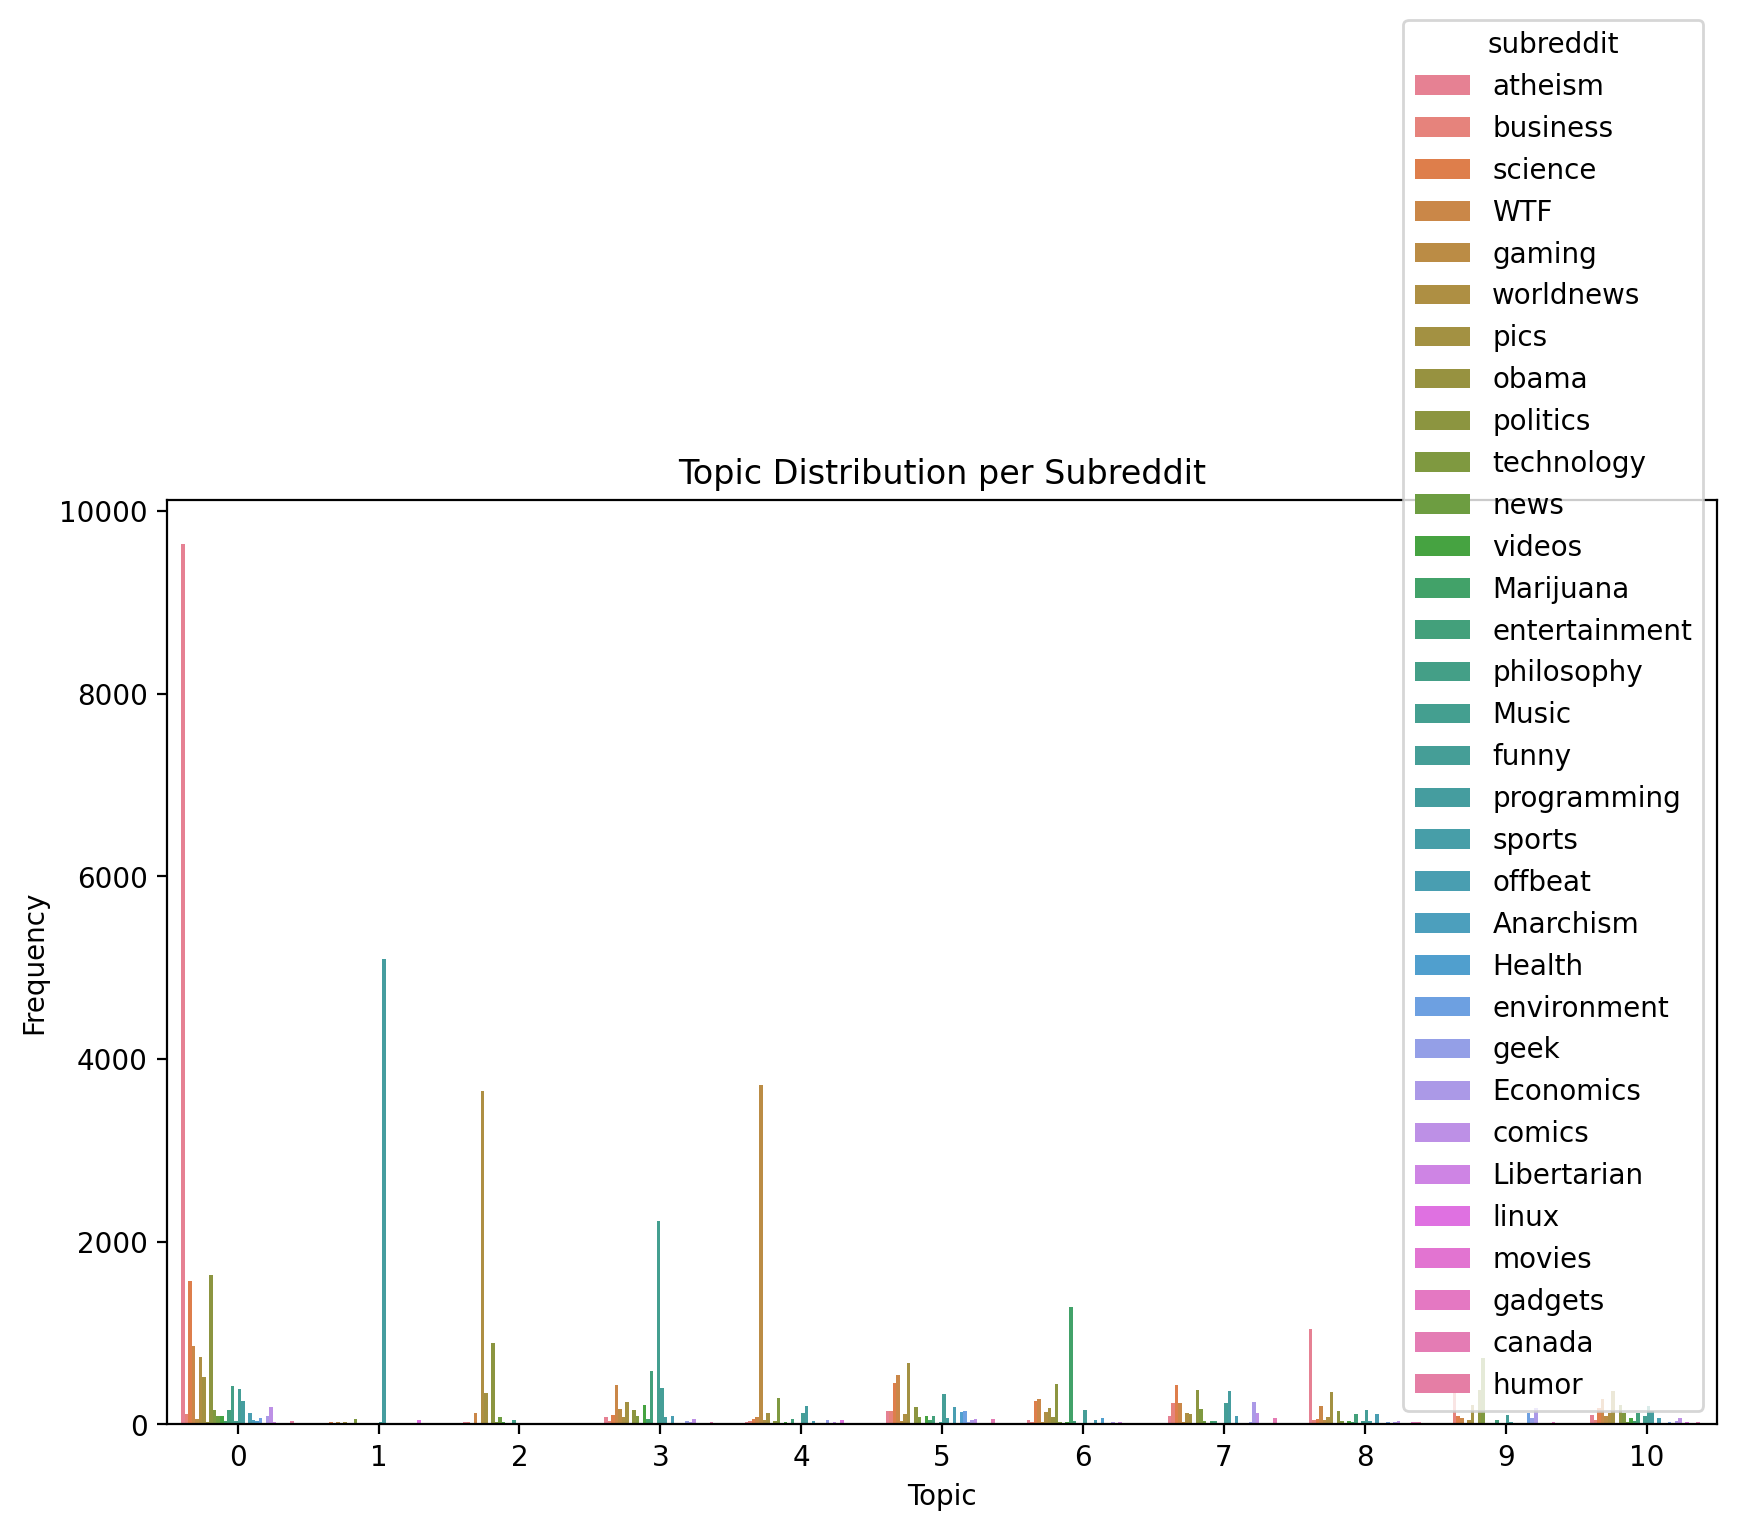

In [39]:
top_10_df = df[(df['topic_2'] <= 10) & (df['topic_2'] >= 0)]
# Plot the topic names and the subreddit
plt.figure(figsize=(10,6))
sns.countplot(x='topic_2', hue='subreddit', data=top_10_df)
plt.title('Topic Distribution per Subreddit')
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.show()

Its too hard to see if the topics match the subreddit so I will take for each topic the most common subreddit.

In [40]:
# Get the most common subreddit for each topic
top_10_df = top_10_df.groupby('topic_2')['subreddit'].agg(lambda x: x.value_counts().index[0]).reset_index()
top_10_df

,topic_2,subreddit
0,0,atheism
1,1,programming
2,2,worldnews
3,3,Music
4,4,gaming
5,5,pics
6,6,Marijuana
7,7,science
8,8,atheism
9,9,technology


Now I will compare it with the name of the topic

In [41]:
freq2 = topic_model.get_topic_info()
freq2.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,209619,-1_people_like_gt_think,"[people, like, gt, think, time, make, money, t...",[one brian co worker story fucked try best exp...
1,0,17520,0_god_atheist_religion_christian,"[god, atheist, religion, christian, belief, re...",[linguistics limited college paper really will...
2,1,5454,1_language_programming_java_code,"[language, programming, java, code, python, pr...","[programming, programming, programming]"
3,2,5351,2_israel_palestinian_hamas_israeli,"[israel, palestinian, hamas, israeli, rocket, ...","[movie side israel, necessarily israel admit e..."
4,3,5345,3_song_music_album_band,"[song, music, album, band, guitar, listen, pun...",[one people lot band absolutely ca stand like ...
5,4,5083,4_game_play_steam_wii,"[game, play, steam, wii, console, pc, played, ...",[gt like kind game normal gamers like said lik...
6,5,3825,5_eat_food_fat_chicken,"[eat, food, fat, chicken, meat, eating, diet, ...","[great eat, eat, eat]"
7,6,3333,6_drug_marijuana_smoke_weed,"[drug, marijuana, smoke, weed, smoking, pot, c...","[marijuana helluva drug, also always coughed b..."
8,7,3248,7_school_college_teacher_student,"[school, college, teacher, student, education,...","[hundred student, nope cookeville high school,..."
9,8,2769,8_christmas_santa_holiday_gift,"[christmas, santa, holiday, gift, celebrate, m...","[merry christmas, merry christmas, song see mu..."


In [42]:
# join the topic name
top_10_df['topic_name'] = top_10_df['topic_2'].apply(lambda x: freq2[freq2['Topic'] == x]['Name'].values[0])

In [43]:
# show only unique values
top_10_df[['topic_name','subreddit']].drop_duplicates().sort_values('topic_name')

,topic_name,subreddit
0,0_god_atheist_religion_christian,atheism
10,10_desu_fuck fuck_fuck_da,pics
1,1_language_programming_java_code,programming
2,2_israel_palestinian_hamas_israeli,worldnews
3,3_song_music_album_band,Music
4,4_game_play_steam_wii,gaming
5,5_eat_food_fat_chicken,pics
6,6_drug_marijuana_smoke_weed,Marijuana
7,7_school_college_teacher_student,science
8,8_christmas_santa_holiday_gift,atheism


It seems to match the decription. 
1. 0_god_atheist_religion_christian (atheism): This topic name reflects discussions around God, atheism, religion, and Christianity, all of which are relevant to the atheism subreddit, where people often debate religious beliefs, including topics related to the existence of God and different faiths.

2. 10_desu_fuck fuck_fuck_da (pics): The presence of the word "desu" (a common term in anime culture) and the use of informal or slang expressions suggest that this topic is related to internet memes or image-based content. This fits with the pics subreddit, where images, memes, and sometimes nonsensical phrases are shared.

3. 1_language_programming_code_java (programming): This topic name is centered around programming languages, particularly Java, which is a core topic of the programming subreddit, where discussions about coding, software development, and specific languages like Java occur.

4. 2_song_music_album_band (Music): The inclusion of terms like "song," "music," "album," and "band" directly correlates to the Music subreddit, which is dedicated to discussions about various music genres, albums, artists, and songs.

5. 3_israel_palestinian_hamas_israeli (worldnews): This topic name references the Israel-Palestine conflict, as well as Hamas, which are highly relevant to current global news. The worldnews subreddit is often a place for discussions on major international events, including political conflicts.

6. 4_linux_window_apple_ubuntu (programming): This topic involves operating systems like Linux, Windows, Apple (macOS), and Ubuntu, which are frequently discussed in the context of programming, software development, and system administration. Therefore, it fits the programming subreddit, which often delves into topics related to different operating systems for development purposes.

7. 5_game_play_steam_wii (gaming): Keywords like "game," "play," "steam," and "wii" are all related to video games and gaming platforms. This aligns well with the gaming subreddit, where discussions on games, consoles, and platforms are common.

8. 6_eat_food_fat_chicken (pics): "Eat," "food," "fat," and "chicken" are terms related to food and eating, which are often shared as images or in humorous contexts. This fits the pics subreddit, which frequently features images of food, often in a fun or visually appealing way.

9. 7_drug_marijuana_smoke_weed (Marijuana): The terms "drug," "marijuana," "smoke," and "weed" are directly related to cannabis culture and usage. The Marijuana subreddit is dedicated to discussions about marijuana, its use, effects, and culture, making this topic name a perfect match.

10. 8_school_college_teacher_student (science): This topic name focuses on education, with terms like "school," "college," "teacher," and "student." While this could be related to multiple subreddits, it fits well in science, which often includes discussions about education, research, and academic life.

11. 9_christmas_santa_holiday_gift (atheism): While this topic name includes terms like "Christmas," "Santa," "holiday," and "gift," which are traditionally linked to Christian holidays, the atheism subreddit may include discussions around these holidays from a secular or atheistic perspective, critiquing or discussing the societal and cultural aspects of religious holidays.

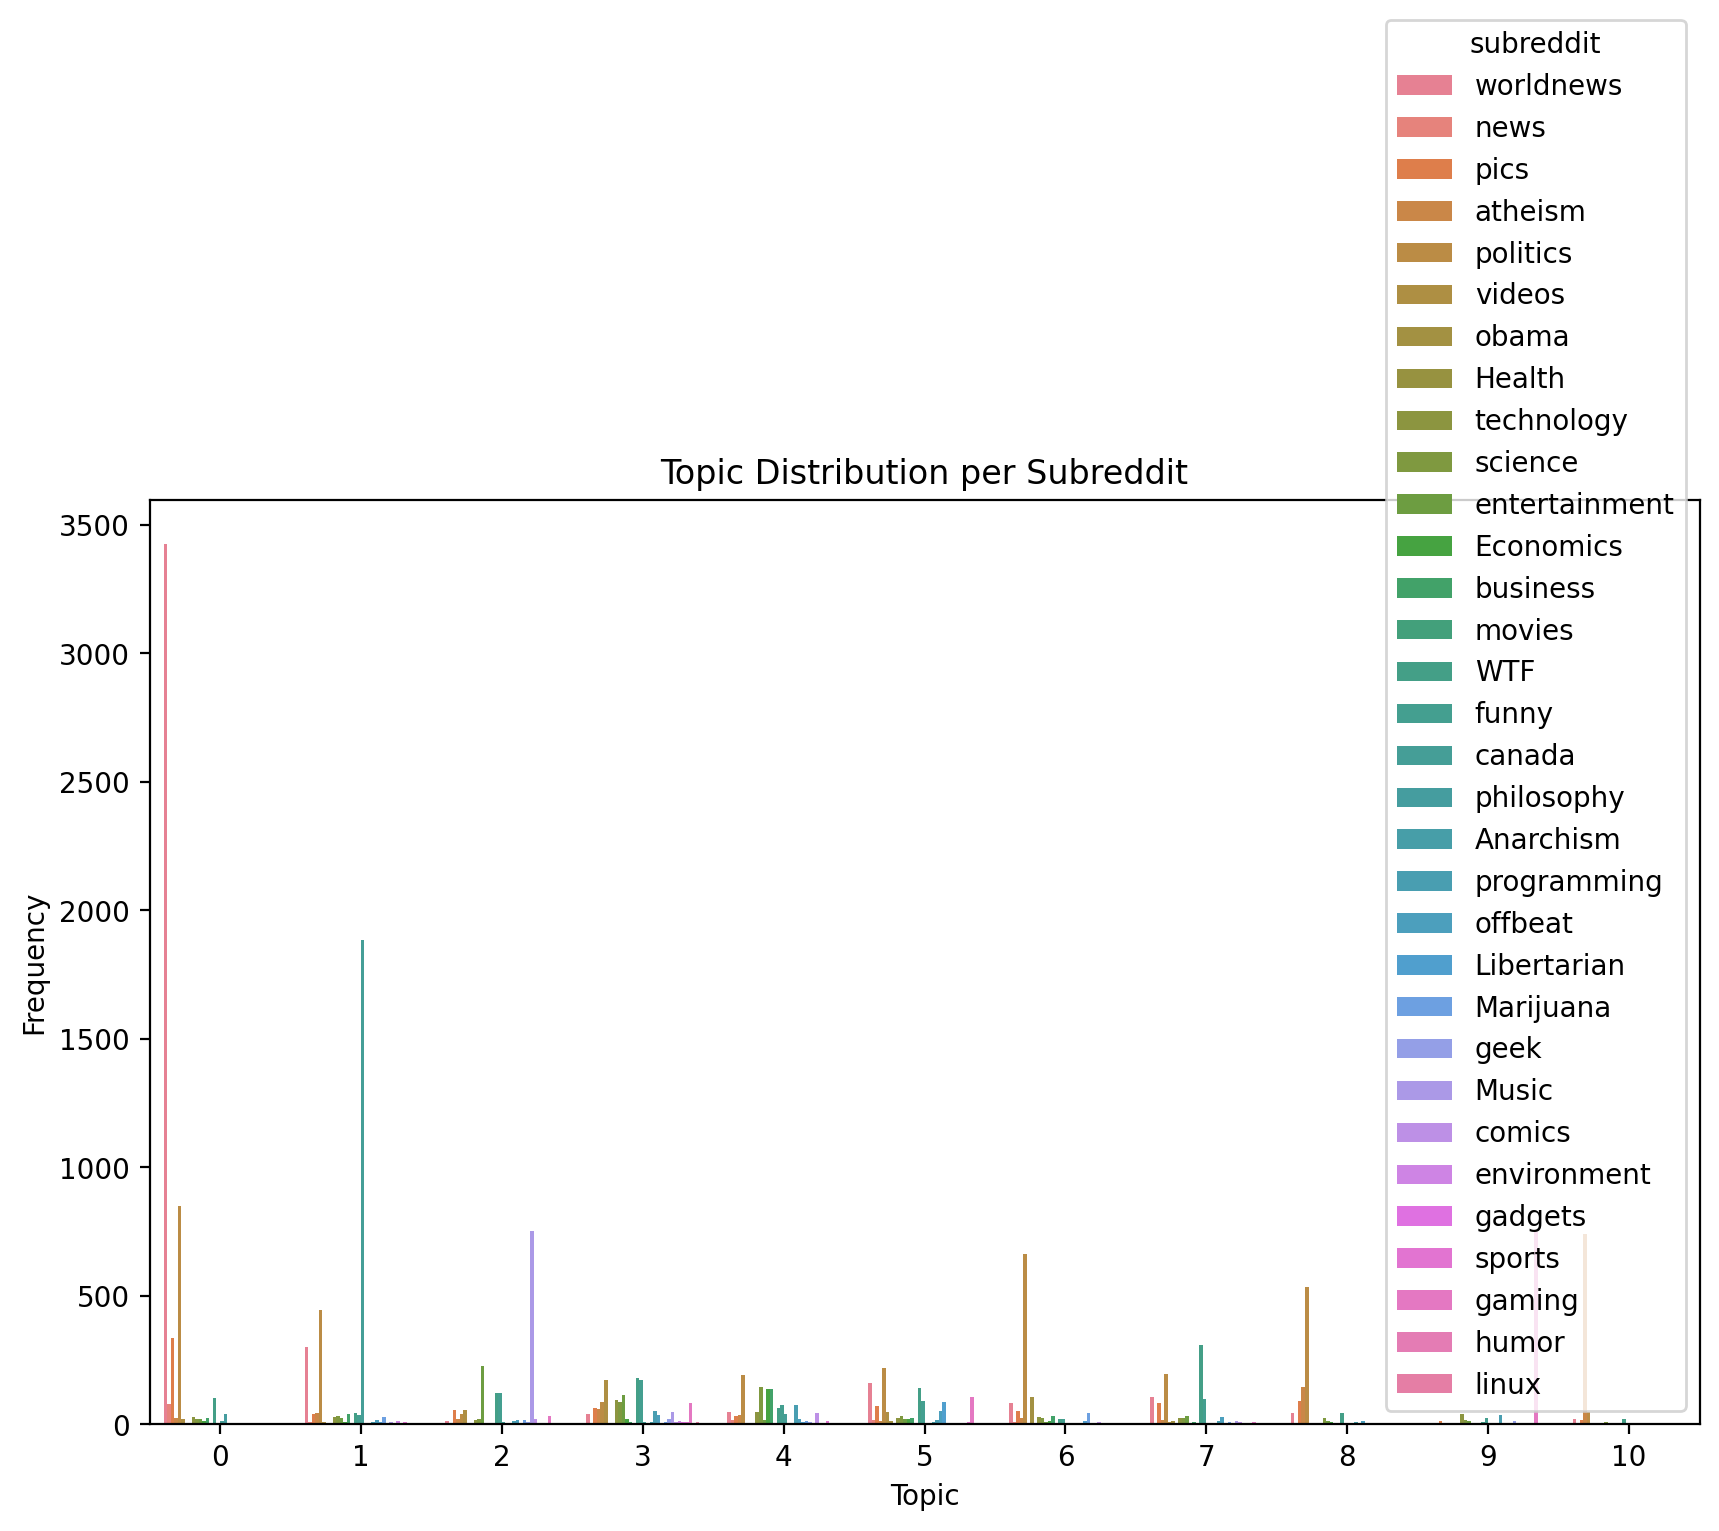

In [44]:
# Now we will do the same for the first model
top_10_df = df[(df['topic_1'] <= 10) & (df['topic_1'] >= 0)]
# Plot the topic names and the subreddit
plt.figure(figsize=(10,6))
sns.countplot(x='topic_1', hue='subreddit', data=top_10_df)
plt.title('Topic Distribution per Subreddit')
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.show()

In [45]:
top_10_df = df[(df['topic_1'] <= 10) & (df['topic_1'] >= 0)]
top_10_df

,author,body,created_utc,subreddit,id,score,word_count,cleaned_body,topic_1,topic_2
17,[deleted],"He's a Rifle man, what should he do?",2008-12-18 08:04:50,WTF,14,2,8,rifle man,5,22
66,[deleted],"The original, Appetite era Guns n' Roses would...",2008-12-18 08:13:26,Music,4p,0,10,original appetite era gun n rose would kick as,5,22
78,cnwb,Why am I getting a video of a little girl eati...,2008-12-18 08:15:18,Music,5n,1,13,getting video little girl eating lollipop,3,19
144,nmcyall,First time I heard it. Didn't watch the full v...,2008-12-18 08:23:41,worldnews,9l,1,11,first time heard watch full video yet,3,19
156,rimwalker,"I am disappointed, no one is claiming that, th...",2008-12-18 08:25:28,worldnews,af,2,66,disappointed one claiming pattern represents w...,7,23
...,...,...,...,...,...,...,...,...,...,...
390251,[deleted],"Aw man, is Obama going to start letting everyo...",2008-12-18 07:45:30,politics,c06vwp0,1,15,aw man obama going start letting everyone voic...,6,21
390264,[deleted],I can make one comment in the atheists subredd...,2008-12-18 07:46:41,atheism,c06vwpv,1,30,make one comment atheist subreddit miracle mir...,10,0
390266,ryanx27,DOUBLE RACISM SCORE,2008-12-18 07:46:43,WTF,c06vwpx,0,3,double racism score,7,23
390305,malcontent,&gt;Just because you disapprove of our methods...,2008-12-18 07:50:38,technology,c06vws4,2,58,gt disapprove method counter palestinian aggre...,0,2


In [46]:
top_10_df = top_10_df.groupby('topic_1')['subreddit'].agg(lambda x: x.value_counts().index[0]).reset_index()
top_10_df['topic_name'] = top_10_df['topic_1'].apply(lambda x: freq1[freq1['Topic'] == x]['Name'].values[0])
top_10_df[['topic_name','subreddit']].drop_duplicates().sort_values('topic_name')

,topic_name,subreddit
0,0_israel_hamas_palestinian_israeli,worldnews
10,10_atheism_atheist_subreddit_athiests,atheism
1,1_harper_coalition_canadian_bloc,canada
2,2_album_song_band_music,Music
3,3_video_youtube_clip_vimeo,WTF
4,4_college_university_school_teacher,politics
5,5_gun_firearm_rifle_handgun,politics
6,6_obama_barack_president_fisa,politics
7,7_racist_racism_white_black,WTF
8,8_marriage_gay_marry_married,politics


**0_israel_palestinian_israeli_hamas – worldnews**: This topic focuses on a significant geopolitical issue involving Israel, Palestine, and Hamas, making it a relevant discussion topic for worldnews, which covers global political affairs and conflicts.

**10_college_university_teacher_school – politics**: Despite the focus on education (colleges, universities, teachers, and schools), this topic fits politics because discussions around education often involve political debates related to funding, policy, and government involvement in education systems.

**1_harper_coalition_canadian_bloc – canada**: The topic revolves around Canadian politics, specifically referencing political figures like Harper and political parties such as the Bloc Quebecois. This makes it an appropriate match for the canada subreddit, which centers on Canadian news and discussions.

**2_atheism_atheist_agnostic_agnosticism** – atheism: The topic name directly mentions atheism, agnosticism, and related beliefs, which are core discussions in the atheism subreddit, making this a perfect fit.

**3_video_youtube_clip_vimeo – WTF**: The WTF subreddit often features strange, unexpected, or humorous content, and videos from platforms like YouTube or Vimeo fit this theme. Videos that are unusual or provoke shock and awe are common in this community.

**4_christmas_holiday_gift_celebrate – atheism**: While Christmas is traditionally a religious holiday, many atheists celebrate the cultural aspects of the holiday (such as gifts and festivities) without the religious context. This makes the topic relevant to atheism, where users discuss their perspectives on secular celebrations.

**5_album_song_band_kanye – Music**: The inclusion of specific music-related terms like "album," "song," and "band" makes this topic directly relevant to the Music subreddit, where users share and discuss music, albums, and artists such as Kanye West.

**6_game_gameplay_mmo_played – gaming:** This topic discusses aspects of video games, including gameplay and specific game genres like MMOs (Massively Multiplayer Online games), making it an ideal match for the gaming subreddit, which is dedicated to video game discussions.

**7_obama_barack_president_fisa** – politics: The reference to Barack Obama, his presidency, and political issues like FISA (Foreign Intelligence Surveillance Act) places this topic squarely in the politics subreddit, which covers political figures, policies, and events.

**8_gun_firearm_rifle_weapon** – politics: The discussion around firearms, guns, and related policies (e.g., Second Amendment rights, gun control) fits well within politics, where such issues are frequently debated.

**9_cop_police_officer_warrant** – politics: The mention of police, officers, and legal concepts like warrants places this topic within politics, as discussions around law enforcement, police practices, and legal rights are highly political in nature.



In [54]:
# Evaluate the model by using the cosin similarity between the topic name and the subreddit
from sklearn.metrics.pairwise import cosine_similarity
# Get the embeddings of the topic names
topic_names = freq1['Name'].unique()
topic_names_embeddings = embedding_model.encode(topic_names, show_progress_bar=True)
# Get the embeddings of the subreddit names
subreddit_names = df['subreddit'].unique()
subreddit_names_embeddings = embedding_model.encode(subreddit_names, show_progress_bar=True)
# Calculate the cosine similarity between the topic names and the subreddit names
cosine_sim = cosine_similarity(topic_names_embeddings, subreddit_names_embeddings)
# Create a dataframe to store the cosine similarity scores
cosine_sim_df = pd.DataFrame(cosine_sim, index=topic_names, columns=subreddit_names)
# Display the cosine similarity dataframe
cosine_sim_df

Batches: 100%|██████████| 1/1 [00:00<00:00, 39.13it/s]


,politics,atheism,programming,Economics,pics,worldnews,business,science,WTF,Marijuana,...,Anarchism,environment,obama,Libertarian,linux,canada,humor,news,gadgets,sports
-1_religion_money_language_science,0.279112,0.387671,0.230244,0.404219,0.045040,0.198253,0.290938,0.415257,0.042098,0.200003,...,0.328433,0.210142,0.100396,0.229131,0.115061,0.157097,0.149978,0.165614,0.171364,0.193102
0_israel_hamas_palestinian_israeli,0.290796,0.189607,0.131248,0.173525,0.145969,0.263863,0.242764,0.180748,0.197691,0.164898,...,0.272373,0.153293,0.268313,0.335994,0.141457,0.257211,0.166282,0.256941,0.079888,0.174668
1_harper_coalition_canadian_bloc,0.261911,0.053827,0.071123,0.177337,0.082099,0.139166,0.143552,0.065505,0.176891,0.121988,...,0.189722,0.061847,0.187579,0.361584,0.023530,0.357949,0.044898,0.199897,0.207341,0.076719
2_album_song_band_music,0.215551,0.100883,0.097734,0.132628,0.182955,0.128854,0.230245,0.277474,0.136532,0.253455,...,0.149812,0.172620,0.135692,0.152113,0.199123,0.096141,0.088894,0.230837,0.167494,0.139039
3_video_youtube_clip_vimeo,0.119922,0.085669,0.082014,0.121852,0.211184,0.146854,0.165599,0.214171,0.130858,0.178721,...,0.048587,0.142783,0.119477,0.152126,0.076311,0.146244,0.167206,0.173575,0.227006,0.177652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037_income_constitution_philosophical_objection,0.219598,0.261361,0.132733,0.319424,0.025512,0.053710,0.224312,0.129051,0.105335,0.100188,...,0.258988,0.163064,0.152058,0.324026,0.131560,0.136967,0.074667,0.079912,0.087023,0.053991
4038_thelogicalsmoker_demographic_hook_loser,0.181636,0.154523,0.108615,0.132503,0.162605,0.193194,0.144993,0.196794,0.190359,0.096869,...,0.104633,0.162877,0.153931,0.163907,0.140498,0.134035,0.126237,0.114315,0.096182,0.131702
4039_hp_holidy_uninstall_compaq,0.003286,0.031163,0.044543,-0.023157,0.081704,0.093923,0.062581,0.003478,0.040018,0.048263,...,-0.031661,0.103820,0.044966,0.035289,0.201855,-0.025460,0.021592,0.037396,0.124074,0.012667
4040_recording_surreptitious_probable_consent,0.107850,0.097016,0.031594,-0.011627,0.092756,0.096073,0.135386,0.091802,0.137343,0.148481,...,0.029474,0.052895,0.079509,0.120928,0.049449,0.140435,0.056261,0.131024,0.022164,0.010669


In [55]:
# Now we can evaluate each topic and his subreddit
top_10_df['subreddit_similarity'] = top_10_df[['topic_name', 'subreddit']].apply(lambda x: cosine_sim_df.loc[x['topic_name'], x['subreddit']], axis=1)
top_10_df

,topic_1,subreddit,topic_name,subreddit_similarity
0,0,worldnews,0_israel_hamas_palestinian_israeli,0.263863
1,1,canada,1_harper_coalition_canadian_bloc,0.357949
2,2,Music,2_album_song_band_music,0.610517
3,3,WTF,3_video_youtube_clip_vimeo,0.130858
4,4,politics,4_college_university_school_teacher,0.138294
5,5,politics,5_gun_firearm_rifle_handgun,0.186665
6,6,politics,6_obama_barack_president_fisa,0.277831
7,7,WTF,7_racist_racism_white_black,0.179229
8,8,politics,8_marriage_gay_marry_married,0.194435
9,9,gaming,9_game_mmo_gameplay_played,0.553696


In [56]:
# Show statistics for each topic
top_10_df.groupby('topic_name')['subreddit_similarity'].describe()

,count,mean,std,min,25%,50%,75%,max
topic_name,,,,,,,,
0_israel_hamas_palestinian_israeli,1.0,0.263863,NaN,0.263863,0.263863,0.263863,0.263863,0.263863
10_atheism_atheist_subreddit_athiests,1.0,0.694814,NaN,0.694814,0.694814,0.694814,0.694814,0.694814
1_harper_coalition_canadian_bloc,1.0,0.357949,NaN,0.357949,0.357949,0.357949,0.357949,0.357949
2_album_song_band_music,1.0,0.610517,NaN,0.610517,0.610517,0.610517,0.610517,0.610517
3_video_youtube_clip_vimeo,1.0,0.130858,NaN,0.130858,0.130858,0.130858,0.130858,0.130858
4_college_university_school_teacher,1.0,0.138294,NaN,0.138294,0.138294,0.138294,0.138294,0.138294
5_gun_firearm_rifle_handgun,1.0,0.186665,NaN,0.186665,0.186665,0.186665,0.186665,0.186665
6_obama_barack_president_fisa,1.0,0.277831,NaN,0.277831,0.277831,0.277831,0.277831,0.277831
7_racist_racism_white_black,1.0,0.179229,NaN,0.179229,0.179229,0.179229,0.179229,0.179229


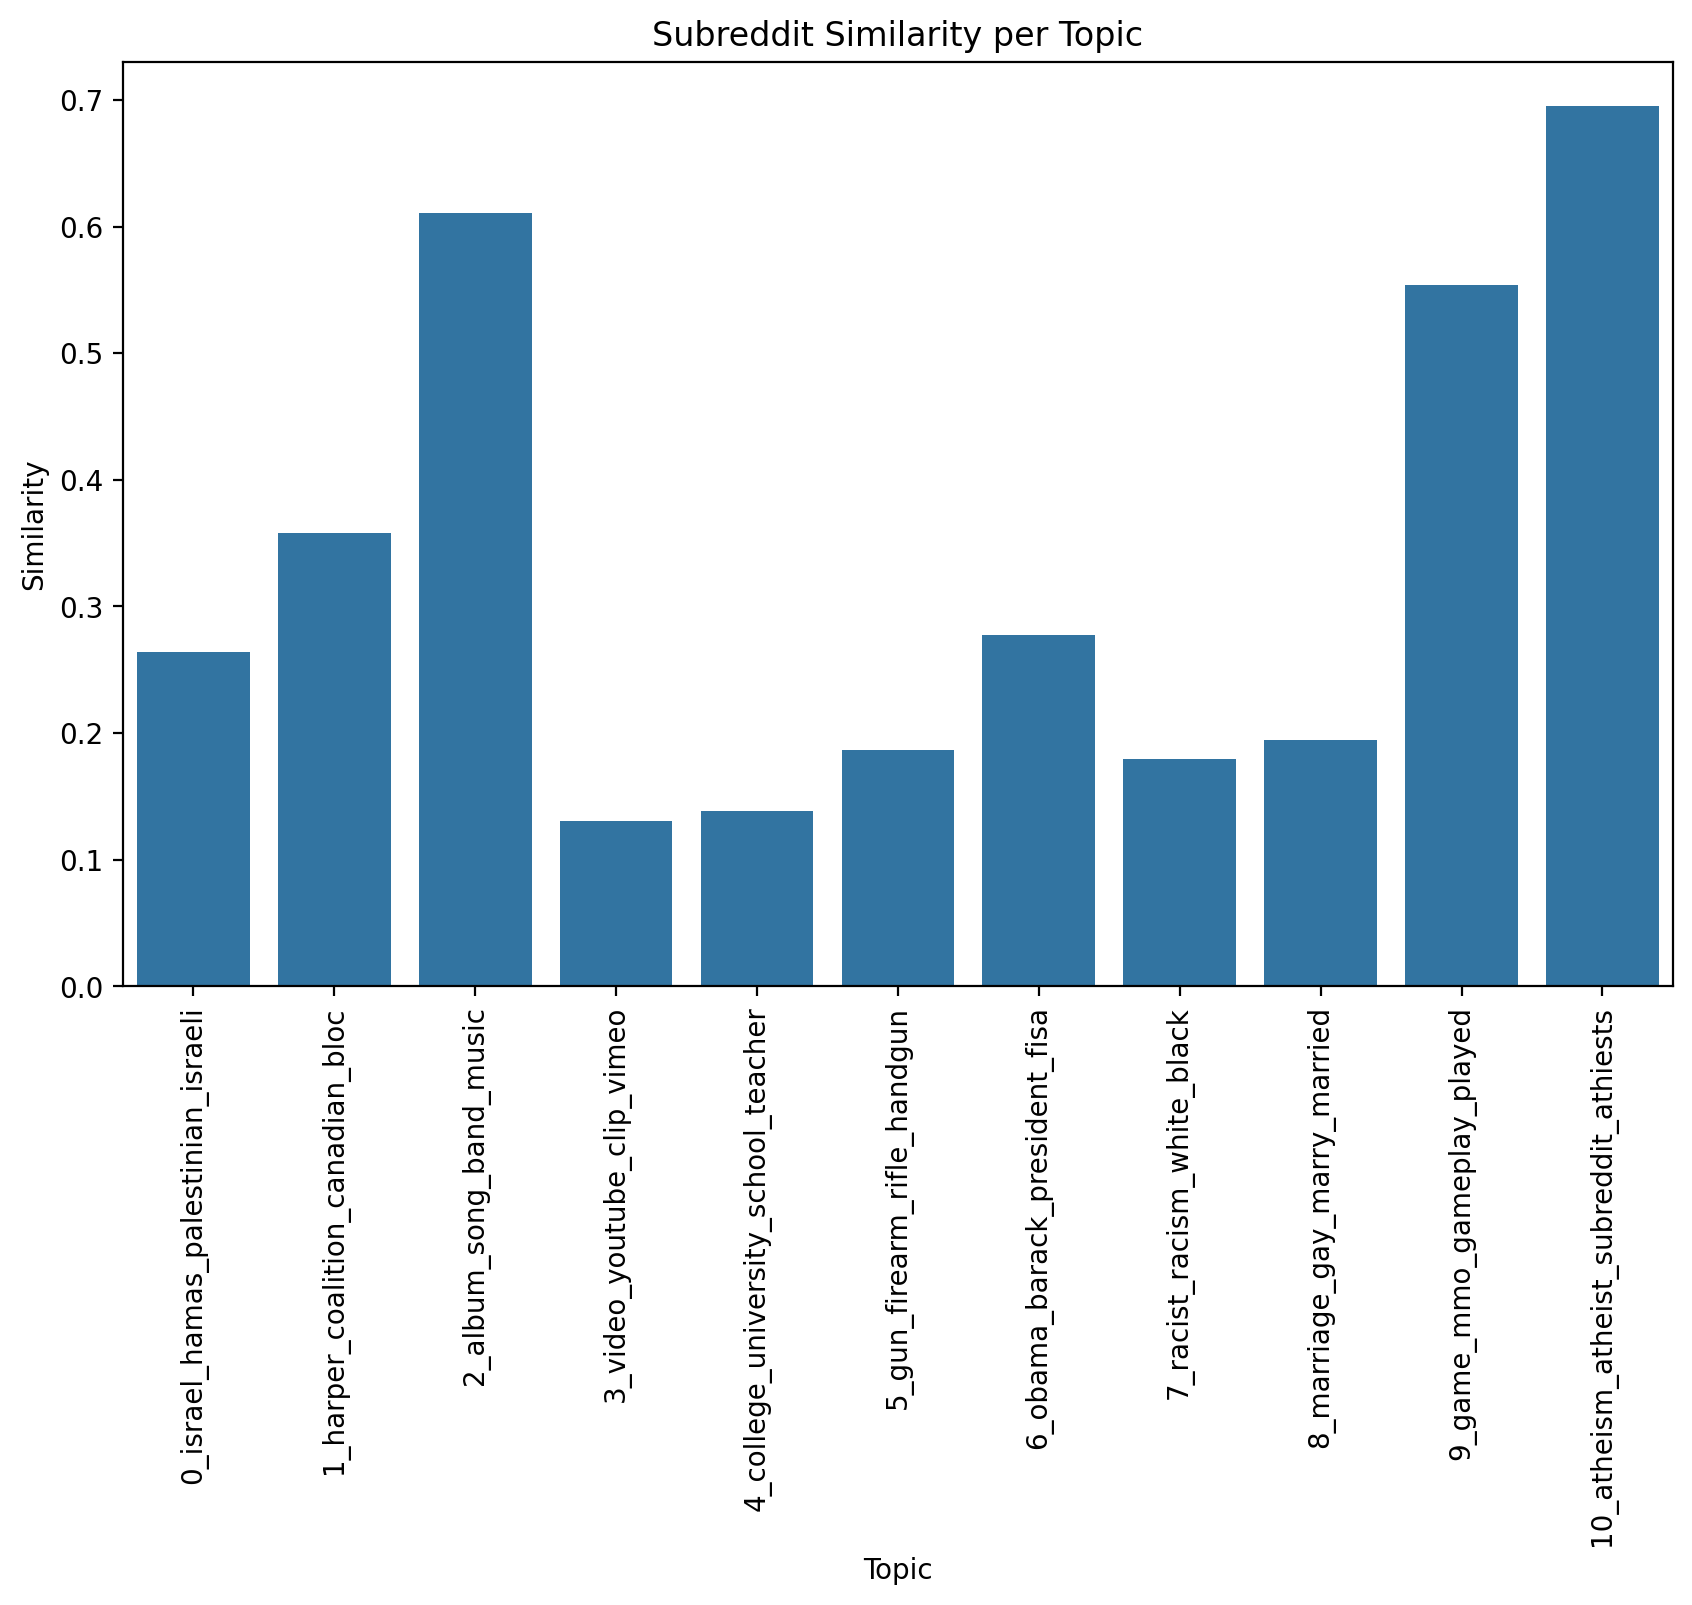

In [57]:
# Plot the similarity scores
plt.figure(figsize=(10,6))
sns.barplot(x='topic_name', y='subreddit_similarity', data=top_10_df)
plt.title('Subreddit Similarity per Topic')
plt.xlabel('Topic')
plt.ylabel('Similarity')
plt.xticks(rotation=90)
plt.show()

# Future thoughts

Here are some potential future improvements for the model:

1. **Using an ensemble approach**: Combining both models could help identify additional features that may not be captured by a single model. This could lead to more robust results and the identification of new, important topics.

2. **Hyperparameter tuning**: Adjusting model parameters, such as clustering size or embedding configurations, can help refine topic detection and uncover previously overlooked topics.

3. **Using different embedding models**: Trying various embedding models (e.g., BERT, GPT-4, or domain-specific models) could significantly enhance the model's ability to capture nuanced relationships in the data, leading to improved results.

4. **Exploring simpler approaches like DTM (Dynamic Topic Modeling)**: Simplifying the approach using DTM, which tracks the evolution of topics over time, could reveal trends and topics that might be missed by more complex models.